<a href="https://colab.research.google.com/github/nischal-p/cis-419-project/blob/main/Advantage_Actor_Critic_for_Mario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cartpole learning with Actor Critic Model

## Installing dependancies for the display

In [1]:
%matplotlib inline
!pip install gym-super-mario-bros==7.3.0
!sudo apt-get install fceux

     |████████████████████████████████| 198 kB 5.4 MB/s 
     |████████████████████████████████| 76 kB 3.4 MB/s 
  Created wheel for nes-py: filename=nes_py-8.1.8-cp37-cp37m-linux_x86_64.whl size=432808 sha256=4946aedb6d086b398770270abf03ee507d3b66cc38808ecdcbf96c8f70e21c12
  Stored in directory: /root/.cache/pip/wheels/f2/05/1f/608f15ab43187096eb5f3087506419c2d9772e97000f3ba025
Successfully built nes-py
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libsdl1.2debian
Suggested packages:
  efp gvfs
The following NEW packages will be installed:
  fceux libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libsdl1.2debian
0 upgraded, 7 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,807 kB of archives.
After this operation, 9,112 kB of additional disk space will be used.
Get:1 http://arc

In [2]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 994 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 994 kB in 1s (982 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 155422 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.1.4-1) ...
Sel

## Importing Stuff

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
from torch.distributions import Categorical
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy
from itertools import count
import os


# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros

## Setting Up stuff

In [4]:
# setting up the display
import pyvirtualdisplay
import matplotlib.pyplot as plt
from IPython import display

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

!echo $DISPLAY

:1001


In [5]:
# setting up environment and paramenters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("SuperMarioBros-1-1-v0")
env = JoypadSpace(env, [["right"], ["right", "A"]])

env.reset()
next_state, reward, done, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

(240, 256, 3),
 0,
 False,
 {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


# Pre-process Environment

In [6]:
device

device(type='cuda')

In [7]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

state_shape = env.observation_space.shape

## The Actor Model

In [8]:
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        c, h, w = self.input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.conv1 = nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.linear1 = nn.Linear(3136, 512)
        self.linear2 = nn.Linear(512, self.output_dim)
        self.flatten = nn.Flatten()

    def forward(self, state):
        output = F.relu(self.conv1(state))
        output = F.relu(self.conv2(output))
        output = F.relu(self.conv3(output))
        output = self.flatten(output)
        output = F.relu(self.linear1(output))
        output = self.linear2(output)
        distribution = Categorical(F.softmax(output, dim=-1))
        return distribution

## The Critic Model


In [9]:
class Critic(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Critic, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        c, h, w = self.input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.conv1 = nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.linear1 = nn.Linear(3136, 512)
        self.linear2 = nn.Linear(512, 1)
        self.flatten = nn.Flatten()

    def forward(self, state):
      output = F.relu(self.conv1(state))
      output = F.relu(self.conv2(output))
      output = F.relu(self.conv3(output))
      output = self.flatten(output)
      output = F.relu(self.linear1(output))
      value = self.linear2(output)
      return value

## Compute returns 

It takes in rewards and computes the return for a certain episode/state using the discount factor

In [10]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns


# Logging

In [11]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'MeanReward':>15}"
                f"{'MeanLength':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0

    def record(self, episode):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_rewards", "ep_lengths"]:
            plt.plot(getattr(self, f"moving_avg_{metric}"))
            plt.savefig(getattr(self, f"{metric}_plot"))
            plt.clf()

# Putting it all together

## Initializing display

In [12]:
import pyvirtualdisplay
import matplotlib.pyplot as plt
from IPython import display

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

!echo $DISPLAY

:1005


## Training

In [15]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
save_dir = Path("/content/gdrive/Shareddrives/CIS 519 Project/mario-a2c-checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

logger = MetricLogger(save_dir)

actor = Actor(input_dim=(4, 84, 84), output_dim=env.action_space.n).to(device)
critic = Critic(input_dim=(4, 84, 84), output_dim=env.action_space.n).to(device)

episodes = 40000

save_every = 1000
log_every = 500

optimizerA = optim.Adam(actor.parameters())
optimizerC = optim.Adam(critic.parameters())

for e in range(1, episodes + 1):
    state = env.reset()
    log_probs = []
    values = []
    rewards = []
    masks = []
    entropy = 0

    # img = plt.imshow(env.render(mode='rgb_array'))

    episode_rewards = 0

    for i in count():

        # Added
        # img.set_data(env.render(mode='rgb_array'))
        # plt.axis('off')
        # display.display(plt.gcf())
        # display.clear_output(wait=True)

        state = state.__array__()
        state = torch.tensor(state).to(device)
        state = state.unsqueeze(0)
        dist = actor(state)
        value = critic(state)

        action = dist.sample()

        next_state, reward, done, info = env.step(int(action))

        logger.log_step(reward)
        episode_rewards += reward

        log_prob = dist.log_prob(action).unsqueeze(0)
        entropy += dist.entropy().mean()

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
        masks.append(torch.tensor([1-done], dtype=torch.float, device=device))

        state = next_state

        if done or info["flag_get"]:
            print(f'Episode: {e}, Reward: {episode_rewards}')
            break
    
    logger.log_episode()

    next_state = next_state.__array__()
    next_state = torch.tensor(next_state).to(device)
    next_state = next_state.unsqueeze(0)

    next_value = critic(next_state)
    returns = compute_returns(next_value, rewards, masks)

    log_probs = torch.cat(log_probs)
    returns = torch.cat(returns).detach()
    values = torch.cat(values)

    advantage = returns - values

    actor_loss = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    optimizerA.zero_grad()
    optimizerC.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    optimizerA.step()
    optimizerC.step()

    if e % log_every == 0:
        logger.record(episode=e)

    if e % save_every == 0:
        torch.save(actor, save_dir / f'actor_{e}.pkl')
        torch.save(critic, save_dir / f'critic{e}.pkl')
# ipythondisplay.clear_output(wait=True)

/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Episode: 1, Reward: 1280.0
Episode: 2, Reward: 626.0
Episode: 3, Reward: 231.0
Episode: 4, Reward: 1041.0
Episode: 5, Reward: 629.0
Episode: 6, Reward: 634.0
Episode: 7, Reward: 231.0
Episode: 8, Reward: 625.0
Episode: 9, Reward: 634.0
Episode: 10, Reward: 748.0
Episode: 11, Reward: 775.0
Episode: 12, Reward: 231.0
Episode: 13, Reward: 635.0
Episode: 14, Reward: 779.0
Episode: 15, Reward: 1282.0
Episode: 16, Reward: 231.0
Episode: 17, Reward: 1024.0
Episode: 18, Reward: 611.0
Episode: 19, Reward: 231.0
Episode: 20, Reward: 593.0
Episode: 21, Reward: 627.0
Episode: 22, Reward: 711.0
Episode: 23, Reward: 217.0
Episode: 24, Reward: 732.0
Episode: 25, Reward: 615.0
Episode: 26, Reward: 628.0
Episode: 27, Reward: 1322.0
Episode: 28, Reward: 934.0
Episode: 29, Reward: 223.0
Episode: 30, Reward: 654.0
Episode: 31, Reward: 757.0
Episode: 32, Reward: 592.0
Episode: 33, Reward: 990.0
Episode: 34, Reward: 710.0
Episode: 35, Reward: 231.0
Episode: 36, Reward: 796.0
Episode: 37, Reward: 587.0
Episo

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

Episode: 0, Reward: 231.0


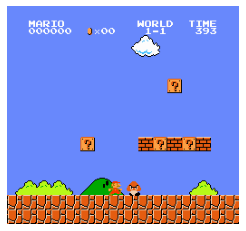

In [ ]:
# for e in range(1):
#     state = env.reset()
#     img = plt.imshow(env.render(mode='rgb_array'))

#     episode_rewards = 0

#     for i in count():

#         # Added
#         img.set_data(env.render(mode='rgb_array'))
#         plt.axis('off')
#         display.display(plt.gcf())
#         display.clear_output(wait=True)

#         state = state.__array__()
#         state = torch.tensor(state).to(device)
#         state = state.unsqueeze(0)
#         dist = actor(state)
#         value = critic(state)

#         action = dist.sample()

#         next_state, reward, done, info = env.step(int(action))

#         episode_rewards += reward

#         state = next_state

#         if done or info["flag_get"]:
#             print(f'Episode: {e}, Reward: {episode_rewards}')
#             break
    
#     logger.log_episode()

